<a href="https://colab.research.google.com/github/yukuo333/ME599-Perception-Task/blob/main/%5CRCNN%5CGet_resized_target_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* *Self-driving Car Final Project --Image Classification*

# Set Up


In [ ]:
import numpy as np
import os
import PIL
import PIL.Image as Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import cv2

# demo needed
from glob import glob
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# training needed
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# Download the trainval dataset 

**Get access to google drive**

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


check position of folder

In [ ]:
!ls '/content/gdrive/MyDrive/rob535-fall2021-final-project-data/'

classes.csv  test  trainval


**Read and print centroids.scv / labels.csv**


In [ ]:
file_centroids = pd.read_csv('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/centroids.csv', header = 0)
file_labels = pd.read_csv('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/labels.csv', header = 0)

In [ ]:
print(file_centroids.info())
print(file_centroids)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22719 entries, 0 to 22718
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   guid/image/axis  22719 non-null  object 
 1   value            22719 non-null  float64
dtypes: float64(1), object(1)
memory usage: 355.1+ KB
None
                                   guid/image/axis      value
0      047b864f-0753-448b-9483-f990ae41abaf/0000/x  24.530764
1      047b864f-0753-448b-9483-f990ae41abaf/0000/y  -5.600761
2      047b864f-0753-448b-9483-f990ae41abaf/0000/z  41.726020
3      047b864f-0753-448b-9483-f990ae41abaf/0001/x  -4.277715
4      047b864f-0753-448b-9483-f990ae41abaf/0001/y  -5.172210
...                                            ...        ...
22714  fc26f4db-22c1-49c7-be8d-b769476cdff2/0194/y  -1.066787
22715  fc26f4db-22c1-49c7-be8d-b769476cdff2/0194/z  18.069616
22716  fc26f4db-22c1-49c7-be8d-b769476cdff2/0195/x  -4.740550
22717  fc26f4db-22c1-49c7-be8

In [ ]:
print(file_labels.info())
print(file_labels)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7573 entries, 0 to 7572
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   guid/image  7573 non-null   object
 1   label       7573 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.5+ KB
None
                                     guid/image  label
0     047b864f-0753-448b-9483-f990ae41abaf/0000      2
1     047b864f-0753-448b-9483-f990ae41abaf/0001      1
2     047b864f-0753-448b-9483-f990ae41abaf/0002      1
3     047b864f-0753-448b-9483-f990ae41abaf/0003      1
4     047b864f-0753-448b-9483-f990ae41abaf/0004      1
...                                         ...    ...
7568  fc26f4db-22c1-49c7-be8d-b769476cdff2/0191      2
7569  fc26f4db-22c1-49c7-be8d-b769476cdff2/0192      2
7570  fc26f4db-22c1-49c7-be8d-b769476cdff2/0193      2
7571  fc26f4db-22c1-49c7-be8d-b769476cdff2/0194      2
7572  fc26f4db-22c1-49c7-be8d-b769476cdff2/0195      2

[7573 rows x 2 c

In [ ]:
label = pd.read_csv('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/labels.csv', usecols=['guid/image'])
print(label.head(5))

                                  guid/image
0  047b864f-0753-448b-9483-f990ae41abaf/0000
1  047b864f-0753-448b-9483-f990ae41abaf/0001
2  047b864f-0753-448b-9483-f990ae41abaf/0002
3  047b864f-0753-448b-9483-f990ae41abaf/0003
4  047b864f-0753-448b-9483-f990ae41abaf/0004


**Read image dataset**

In [ ]:
files = glob('/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/*/*_image.jpg')
print(len(files))
files[:5]

7573


['/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/937869c5-e3b8-42d0-a0ef-5fe03e88c26f/0038_image.jpg',
 '/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/937869c5-e3b8-42d0-a0ef-5fe03e88c26f/0054_image.jpg',
 '/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/937869c5-e3b8-42d0-a0ef-5fe03e88c26f/0056_image.jpg',
 '/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/937869c5-e3b8-42d0-a0ef-5fe03e88c26f/0030_image.jpg',
 '/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/937869c5-e3b8-42d0-a0ef-5fe03e88c26f/0039_image.jpg']

In [ ]:
classes = (
    'Unknown', 'Compacts', 'Sedans', 'SUVs', 'Coupes',
    'Muscle', 'SportsClassics', 'Sports', 'Super', 'Motorcycles',
    'OffRoad', 'Industrial', 'Utility', 'Vans', 'Cycles',
    'Boats', 'Helicopters', 'Planes', 'Service', 'Emergency',
    'Military', 'Commercial', 'Trains'
)

def rot(n):
    n = np.asarray(n).flatten()
    assert(n.size == 3)

    theta = np.linalg.norm(n)
    if theta:
        n /= theta
        K = np.array([[0, -n[2], n[1]], [n[2], 0, -n[0]], [-n[1], n[0], 0]])

        return np.identity(3) + np.sin(theta) * K + (1 - np.cos(theta)) * K @ K
    else:
        return np.identity(3)
def get_bbox(p0, p1):
    """
    Input:
    *   p0, p1
        (3)
        Corners of a bounding box represented in the body frame.

    Output:
    *   v
        (3, 8)
        Vertices of the bounding box represented in the body frame.
    *   e
        (2, 14)
        Edges of the bounding box. The first 2 edges indicate the `front` side
        of the box.
    """
    v = np.array([
        [p0[0], p0[0], p0[0], p0[0], p1[0], p1[0], p1[0], p1[0]],
        [p0[1], p0[1], p1[1], p1[1], p0[1], p0[1], p1[1], p1[1]],
        [p0[2], p1[2], p0[2], p1[2], p0[2], p1[2], p0[2], p1[2]]
    ])
    e = np.array([
        [2, 3, 0, 0, 3, 3, 0, 1, 2, 3, 4, 4, 7, 7],
        [7, 6, 1, 2, 1, 2, 4, 5, 6, 7, 5, 6, 5, 6]
    ], dtype=np.uint8)

    return v, e

**Split files into trainning set and validation set**

In [ ]:
num_split = round(len(files)*0.8)
print(num_split)

6058


**read bbox file**

In [ ]:
# for idx in range(len(files)):

idx = 51
snapshot = files[idx]
print(snapshot)

img = plt.imread(snapshot)
print(img.shape)

xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
xyz = xyz.reshape([3, -1])

proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
proj.resize([3, 4])

try:
    bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
except FileNotFoundError:
    print('[*] bbox not found.')
    bbox = np.array([], dtype=np.float32)

bbox = bbox.reshape([-1, 11])

uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
uv = uv / uv[2, :]


/content/gdrive/MyDrive/rob535-fall2021-final-project-data/trainval/937869c5-e3b8-42d0-a0ef-5fe03e88c26f/0052_image.jpg
(1052, 1914, 3)


[526, 359]
[37, -489, 726, 367]
(359, 0, 3)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


ValueError: ignored

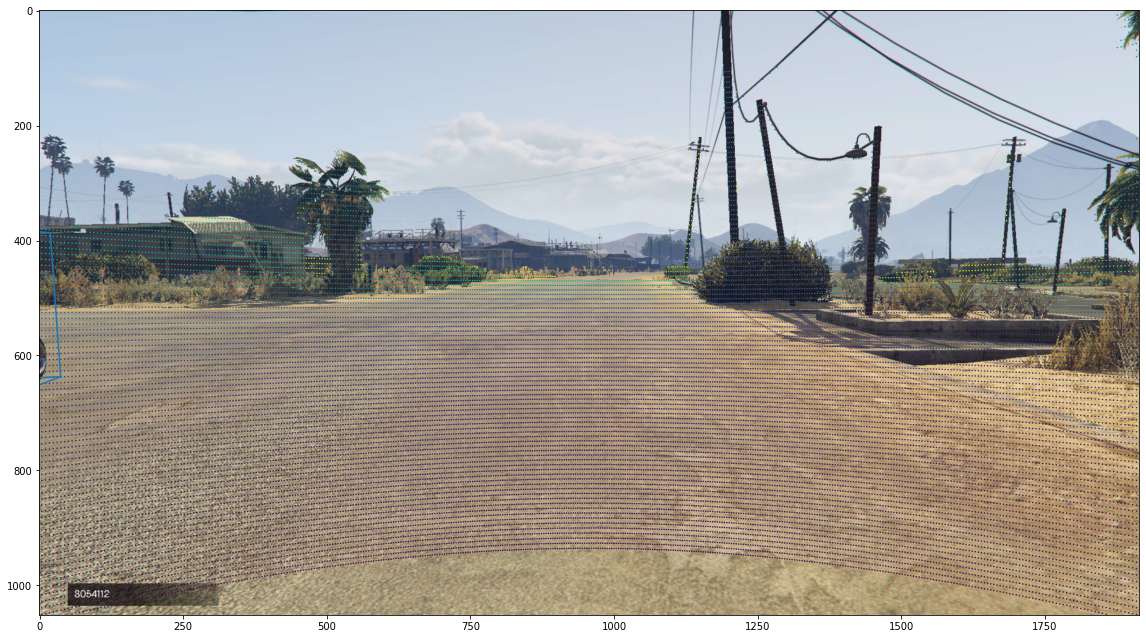

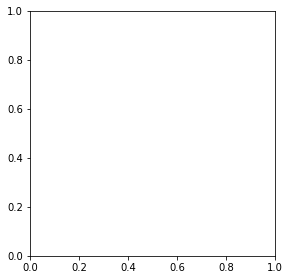

In [ ]:
dist = np.linalg.norm(xyz, axis=0)
fig1 = plt.figure(1, figsize=(16, 9))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.imshow(img)
ax1.scatter(uv[0, :], uv[1, :], c=dist, marker='.', s=1)
ax1.axis('scaled')
fig1.tight_layout()

step = 5

colors = ['C{:d}'.format(i) for i in range(10)]
for k, b in enumerate(bbox):
    R = rot(b[0:3])
    t = b[3:6]

    sz = b[6:9]
    vert_3D, edges = get_bbox(-sz / 2, sz / 2)
    vert_3D = R @ vert_3D + t[:, np.newaxis]

    vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
    vert_2D = vert_2D / vert_2D[2, :]

    ax1 = fig1.add_subplot(1, 1, 1)
    ax1.imshow(img)

    
    clr = colors[np.mod(k, len(colors))]
    for e in edges.T:
        ax1.plot(vert_2D[0, e], vert_2D[1, e], color=clr)

# boundary contain all the vehilce
maxx,minx,maxy,miny = round( max(vert_2D[0,:])), round(min(vert_2D[0,:])), round (max(vert_2D[1,:])) , round(min(vert_2D[1,:]))
maxx, minx, maxy, miny = min(max(maxx,0),1914), min(max(minx,0),1914), min(max(maxy,0),1052), min(max(miny,0),1052)

print([maxx,minx, maxy,miny])
cut_image = img[miny:maxy, minx:maxx,:]
print(cut_image.shape)
fig2 = plt.figure(2, figsize=(8, 4.5))
ax2 = fig2.add_subplot(1, 1, 1)
ax2.imshow(cut_image)


plt.show()

# Cutting image reshape

172 103 <class 'numpy.ndarray'>
(120, 200, 3)


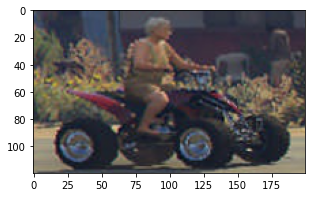

In [ ]:
def Reshape_img(img, basewidth, baseheight):
  [h,w,_] = img.shape
  print(w,h,type(img))
  wpercent = basewidth/float(w)
  new_h = int((float(h) * float(wpercent)))
  img_reshaped = cv2.resize(img, dsize=(baseheight, basewidth), interpolation=cv2.INTER_CUBIC)
  print(img_reshaped.shape)

  # display the reshped figure
  fig3 = plt.figure(3, figsize=(8, _))
  ax3 = fig3.add_subplot(1, 1, 1)
  ax3.imshow(img_reshaped)

  #return img_reshaped
  
Reshape_img(cut_image, 120, 200)

In [ ]:
baseheight, basewidth = 224, 224
img_reshaped = cv2.resize(cut_image, dsize=(baseheight, basewidth), interpolation=cv2.INTER_CUBIC)
im = Image.fromarray(img_reshaped)

save_folder = '/content/gdrive/MyDrive/cutimg_224/'
s_arr = snapshot.split('/')
s_guidimage = '/'.join(s_arr[-2:])[:-10]
label_here = list(file_labels[ file_labels['guid/image'] == s_guidimage ]['label'])[0]

save_dir = save_folder + str(label_here) +'/'+ '_'.join(s_arr[-2:])[:-10] + '_cutimg.jpg'
im.save(save_dir)

# Loop to get the target reshaped images and save to the classifed folder in drive

In [ ]:
baseheight, basewidth = 224, 224
save_folder = '/content/gdrive/MyDrive/cutimg_224/'
train_images=[]
train_labels=[]

#for idx in range(num_split):
for idx in range(num_split,len(files)):
  snapshot = files[idx]
  img = plt.imread(snapshot)

  xyz = np.fromfile(snapshot.replace('_image.jpg', '_cloud.bin'), dtype=np.float32)
  xyz = xyz.reshape([3, -1])

  proj = np.fromfile(snapshot.replace('_image.jpg', '_proj.bin'), dtype=np.float32)
  proj.resize([3, 4])

  try:
    bbox = np.fromfile(snapshot.replace('_image.jpg', '_bbox.bin'), dtype=np.float32)
  except FileNotFoundError:
    continue
      #print('[*] bbox not found.')
      #bbox = np.array([], dtype=np.float32)

  bbox = bbox.reshape([-1, 11])
  uv = proj @ np.vstack([xyz, np.ones_like(xyz[0, :])])
  uv = uv / uv[2, :]
  dist = np.linalg.norm(xyz, axis=0)
  
  step = 5
  colors = ['C{:d}'.format(i) for i in range(10)]
  for k, b in enumerate(bbox):
      R = rot(b[0:3])
      t = b[3:6]
      sz = b[6:9]
      vert_3D, edges = get_bbox(-sz / 2, sz / 2)
      vert_3D = R @ vert_3D + t[:, np.newaxis]
      vert_2D = proj @ np.vstack([vert_3D, np.ones(vert_3D.shape[1])])
      vert_2D = vert_2D / vert_2D[2, :]

      clr = colors[np.mod(k, len(colors))]

  # boundary contain all the vehilce
  maxx,minx,maxy,miny = round( max(vert_2D[0,:])), round(min(vert_2D[0,:])), round (max(vert_2D[1,:])) , round(min(vert_2D[1,:]))
  maxx, minx, maxy, miny = min(max(maxx,0),1914), min(max(minx,0),1914), min(max(maxy,0),1052), min(max(miny,0),1052)
  if maxx<=minx or maxy<=miny:
    continue
  cut_image = img[miny:maxy, minx:maxx,:]

  img_reshaped = cv2.resize(cut_image, dsize=(baseheight, basewidth), interpolation=cv2.INTER_CUBIC)
  
  im = Image.fromarray(img_reshaped)
  s_arr = snapshot.split('/')

  label_here = list(file_labels[ file_labels['guid/image'] == '/'.join(s_arr[-2:])[:-10] ]['label'])[0]

  save_dir = save_folder + str(label_here) +'/'+ '_'.join(s_arr[-2:])[:-10] + '_cutimg.jpg'
  im.save(save_dir)

  #train_images.append(img_reshaped)
  #train_labels.append(label_here)



In [ ]:
cutfiles = glob('/content/gdrive/MyDrive/cutimg_224/*/*_cutimg.jpg')
print(len(cutfiles))

7573


In [ ]:
cutfiles = glob('/content/gdrive/MyDrive/cutimg_224/*/*_cutimg.jpg')